# Session 3 — Building & Orchestrating Data Pipelines

Design, schedule, and monitor robust batch/stream pipelines. Introduce NoSQL data types lightly for pipeline context.


## 🧭 1️⃣ Introduction to Data Pipelines

A **data pipeline** is a sequence of tasks that **ingest**, **transform**, and **deliver** data from sources to targets (warehouse, lake, or BI tools).  
In production, pipelines must be **automated, observable, and reliable**.

**Why orchestration?**
- Define **order** of tasks (dependencies)
- Coordinate **retries**, **timeouts**, and **alerts**
- Parameterize runs by date/partition
- Centralize monitoring and lineage



## 🧩 2️⃣ Pipeline Components

| Layer | Examples | Purpose |
|------|----------|---------|
| Sources | OLTP DBs, APIs, Files | Raw business/operational data |
| Storage | S3 / ADLS | Landing/staging/curated zones |
| Compute | Databricks, Glue, EMR, Synapse Spark | Transform/clean/enrich |
| Warehouse | Redshift, Synapse | Serve analytics (BI/SQL) |
| Orchestration | Airflow, ADF, Step Functions | Schedule, dependencies, retries |
| Monitoring | CloudWatch, Azure Monitor, Airflow UI | Run health, logs, metrics |



## 🔗 3️⃣ Workflow Orchestration (DAGs, Dependencies, Retries)

**DAG (Directed Acyclic Graph)**: a graph of tasks with one-way dependencies (no cycles).  
Key ideas:
- **Idempotency**: rerun produces the same result (safe retries)
- **Backfills**: re-run historical dates/partitions
- **Parallelism**: independent tasks can run concurrently
- **SLA/SLI/SLO**: expected duration & reliability targets



## ⚙️ 4️⃣ Parameterization & Config-Driven Pipelines

Make pipelines **reusable** and **environment-agnostic** by passing parameters (e.g., run date, S3 paths).  
Store configs in **YAML/JSON** or use platform-native variables (Airflow Variables, ADF parameters).

**Benefits**: less code duplication, easier testing, safer promotions (dev → prod).



## ⏱️ 5️⃣ Job Scheduling and Monitoring (Theory First)

**Scheduling** defines when jobs run and in what order. **Monitoring** ensures they run correctly and fast enough.

### 🕒 Scheduling Concepts
- **Triggers**: time-based (cron: hourly/daily) or **event-based** (file arrived in S3)
- **Dependencies**: upstream/downstream ordering
- **Retries**: automatic recovery from transient errors
- **Concurrency**: prevent overlapping runs (one-at-a-time)
- **Parameterization**: pass run-time values (e.g., `{{ ds }}` in Airflow)

### 📈 What to Monitor
- Run status (success/failure)
- Duration trends (regressions)
- Row counts, DQ checks, nulls/dupes
- Cost/throughput in cloud compute

### 🔧 Monitoring Tooling
- **Airflow UI & logs**
- **Azure Monitor + ADF run history**
- **AWS CloudWatch (Glue/Step Functions)**
- **Custom dashboards** (Grafana/Prometheus)


## 🖼️ 6️⃣ Visual: Orchestrated Pipeline Flow

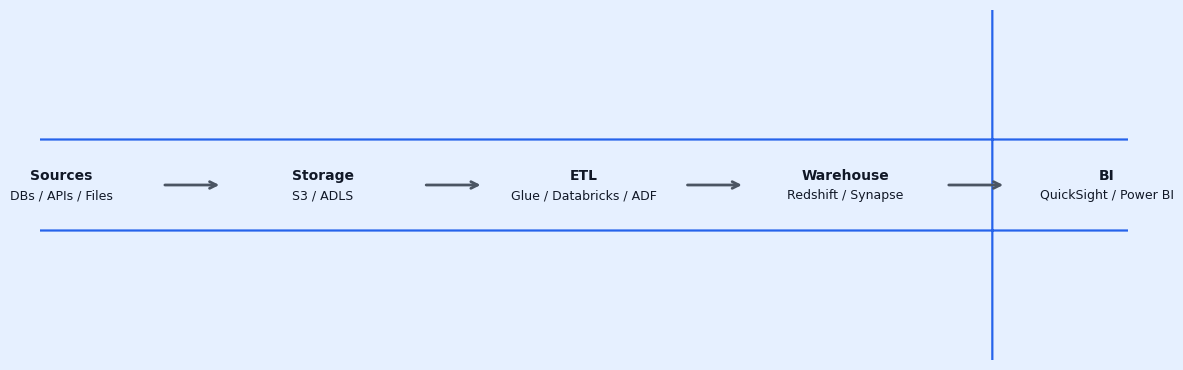

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

BG = "#e6f0ff"; FILL = "#e6f0ff"; EDGE = "#2563eb"; TXT = "#111827"
W, H, GAP, PAD = 0.17, 0.22, 0.07, 0.010
Y0 = 0.39

labels = [
    ("Sources", "DBs / APIs / Files"),
    ("Storage", "S3 / ADLS"),
    ("ETL", "Glue / Databricks / ADF"),
    ("Warehouse", "Redshift / Synapse"),
    ("BI", "QuickSight / Power BI")
]

fig, ax = plt.subplots(figsize=(12, 3.8))
fig.patch.set_facecolor(BG); ax.set_facecolor(BG); ax.set_axis_off()
ax.set_xlim(0, 1); ax.set_ylim(0, 1)

total_w = len(labels)*W + (len(labels)-1)*GAP
x_start = (1 - total_w) / 2
xs = [x_start + i*(W+GAP) for i in range(len(labels))]

def box(x, title, sub):
    r = FancyBboxPatch((x, Y0), W, H, boxstyle="round,pad=0.02,rounding_size=10",
                       fc=FILL, ec=EDGE, lw=1.6)
    ax.add_patch(r)
    ax.text(x+W/2, Y0+H*0.62, title, ha="center", va="center", fontsize=10, color=TXT, fontweight="bold")
    ax.text(x+W/2, Y0+H*0.36, sub, ha="center", va="center", fontsize=9, color=TXT)

for (t,s), x in zip(labels, xs):
    box(x, t, s)

y_mid = Y0 + H/2
for i in range(len(xs)-1):
    x1 = xs[i] + W + PAD; x2 = xs[i+1] - PAD
    ax.annotate("", xy=(x2, y_mid), xytext=(x1, y_mid),
                arrowprops=dict(arrowstyle="->", lw=2, color="#4b5563",
                                shrinkA=0, shrinkB=0, mutation_scale=12))

ax.margins(x=0.05, y=0.10)
plt.tight_layout(); plt.show()


## 🧪 7️⃣ Hands-On: Mini Orchestration Examples

### 7.1 Airflow-style DAG (pseudocode)

```python
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime

def extract(**ctx): ...
def transform(**ctx): ...
def load(**ctx): ...

with DAG(
    "orders_etl",
    start_date=datetime(2025, 10, 22),
    schedule_interval="@daily",
    catchup=False,
    max_active_runs=1,
) as dag:
    t1 = PythonOperator(task_id="extract", python_callable=extract)
    t2 = PythonOperator(task_id="transform", python_callable=transform)
    t3 = PythonOperator(task_id="load", python_callable=load)
    t1 >> t2 >> t3
```

### 7.2 Parameterization (date partition)
- Use `{{ ds }}` (Airflow) or ADF pipeline parameters (e.g., `runDate`) to drive input paths like `s3://.../year=YYYY/month=MM/day=DD/`.



## 📡 8️⃣ Batch vs Real-Time Pipelines

| Aspect | Batch | Real-Time / Streaming |
|--|--|--|
| Latency | Minutes to hours | Milliseconds to seconds |
| Throughput | High volume batches | Continuous events |
| Tools | Airflow, ADF, Glue Jobs | Kinesis / Event Hubs / Kafka |
| Storage | Lake/Warehouse tables | Streams + lake append |
| Use Cases | Daily sales, monthly KPIs | Clickstreams, fraud detection |



## 📦 9️⃣ Structured vs Semi-Structured vs Unstructured Data

Modern pipelines ingest more than relational tables. Knowing the **data type** guides storage and processing choices.

### 🧱 Structured
- Fixed schema (rows/columns), strict types
- **Files**: CSV, TSV, Excel
- **Systems**: Postgres, MySQL, SQL Server, Oracle
- **Query**: SQL

### 🧩 Semi-Structured
- Flexible fields, nested structure
- **Files**: JSON, XML, Parquet, Avro, YAML, Logs
- **Systems**: MongoDB, Cosmos DB, DynamoDB, Cassandra
- **Query**: SQL-like / JSONPath / document queries

### 🗃️ Unstructured
- No inherent schema (text/binary)
- **Files**: PDFs, images, audio, video, emails
- **Systems**: Object stores (S3, ADLS), HDFS, search engines (Elastic)
- **Processing**: NLP, OCR, CV, speech-to-text


### 🖼️ Visual: Data Types & Examples

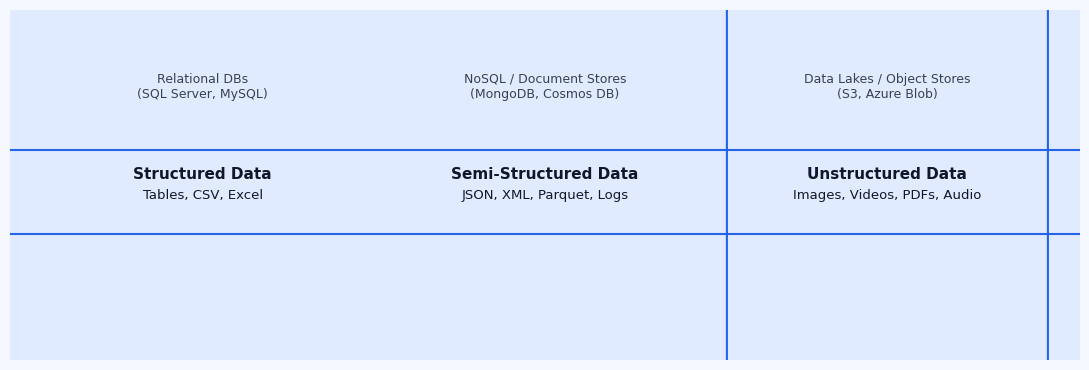

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

BG   = "#f5f9ff"
FILL = "#e0ebff"
EDGE = "#2563eb"
TXT  = "#111827"; TITLE = "#0f172a"

W, H = 0.26, 0.20
GAP  = 0.06
Y0   = 0.38

labels = [
    ("Structured Data", "Tables, CSV, Excel", "Relational DBs\n(SQL Server, MySQL)"),
    ("Semi-Structured Data", "JSON, XML, Parquet, Logs", "NoSQL / Document Stores\n(MongoDB, Cosmos DB)"),
    ("Unstructured Data", "Images, Videos, PDFs, Audio", "Data Lakes / Object Stores\n(S3, Azure Blob)"),
]

fig, ax = plt.subplots(figsize=(11, 3.8))
fig.patch.set_facecolor(BG); ax.set_facecolor(BG); ax.set_axis_off()
ax.set_xlim(0, 1); ax.set_ylim(0, 1)

total_w = len(labels)*W + (len(labels)-1)*GAP
start_x = (1 - total_w) / 2
xs = [start_x + i*(W+GAP) for i in range(len(labels))]

def box(x, title, examples, systems):
    r = FancyBboxPatch((x, Y0), W, H, boxstyle="round,pad=0.02,rounding_size=10",
                       fc=FILL, ec=EDGE, lw=1.5)
    ax.add_patch(r)
    ax.text(x+W/2, Y0+H*0.75, title, ha="center", va="center", fontsize=11, fontweight="bold", color=TITLE)
    ax.text(x+W/2, Y0+H*0.45, examples, ha="center", va="center", fontsize=9.5, color=TXT)
    ax.text(x+W/2, Y0+H*2.0, systems, ha="center", va="center", fontsize=9, color="#374151")

for (t, ex, sys), x in zip(labels, xs):
    box(x, t, ex, sys)

plt.tight_layout(); plt.show()


## ☁️ 🔀 1️⃣0️⃣ Cloud Orchestration Mapping (AWS + Azure)

| Layer | Azure | AWS | Notes |
|--|--|--|--|
| Orchestration | Azure Data Factory | AWS Step Functions / MWAA | Schedule/monitor workflows |
| Compute | Azure Databricks / Synapse Spark | AWS Glue / EMR | Batch transforms |
| Storage | ADLS Gen2 | S3 | Lake zones (raw/curated) |
| Warehouse | Synapse | Redshift | BI-serving SQL |
| Monitoring | Azure Monitor | CloudWatch | Metrics/logs/alerts |



## 💡 1️⃣1️⃣ Practice / Capstone Tasks

1) **Build a DAG** (3 tasks): extract → transform → load. Add retries and a single active run at a time.  
2) **Parameterize** by date: load only the partition for `{{ ds }}` (Airflow) or ADF `runDate`.  
3) **Add monitoring**: capture run times and row counts; emit an alert on failure.  
4) **Extend**: add a branch that loads from a **NoSQL** source (e.g., JSON/Document DB) and merges into your warehouse.
